# Sparkify Capstone Project Part1 - Data Exploration

import library

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

create spark session and load data

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
path = "medium-sparkify-event-data.json"
spark_df = spark.read.json(path)



In [3]:
spark_df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

Based on the general view of the data table. Here is what I found:
The data contains users' interactions with sparkify services. When a user interacted with the service, the event will be recorded. The types of event is reflected in page columns. When the event is associated with music play, such as'NextSong', the corresponding song name and artists name will be recorded. Otherwise, it will show null.
In addition, each event belongs to a specific session. 

## Clean and Transformation

empty user Id and sessionIDs are minor in the dataset. Therefore, records with empty user ID and session ID will be removed.

In [4]:
# remove empyt user ID and sessionID
spark_df_clean=spark_df.filter(spark_df["userId"]!="")
spark_df_clean=spark_df_clean.dropna(how="any",subset=["userId",'sessionId'])

the ts column records the time when each event happened. However, it needs to be encoded into specific year, month, day, hour, minutes and seconds.

In [5]:
# convert ts to real time
gen_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
spark_df_clean = spark_df_clean.withColumn("time", gen_time(spark_df_clean['ts']))

In [6]:
# get hour, weekday and day
gen_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
spark_df_clean = spark_df_clean.withColumn("hour", gen_hour(spark_df_clean['ts']))

gen_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
spark_df_clean = spark_df_clean.withColumn("weekday", gen_weekday(spark_df_clean['ts']))

gen_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
spark_df_clean = spark_df_clean.withColumn("day", gen_day(spark_df_clean['ts']))

In [7]:
# convert ts to real time
gen_time_ymd = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
spark_df_clean = spark_df_clean.withColumn("time_ymd", gen_time_ymd(spark_df_clean['ts']))

In [8]:
# convert ts to time interval_week
gen_time_weel_interval = udf(lambda x: int(x/1000/60/60/24/7))
spark_df_clean = spark_df_clean.withColumn("time_week", gen_time_weel_interval(spark_df_clean['ts']))

In [9]:
# convert ts to time interval_half_month
gen_time_hm_interval = udf(lambda x: int(x/1000/60/60/24/7/15))
spark_df_clean = spark_df_clean.withColumn("time_half_month", gen_time_hm_interval(spark_df_clean['ts']))

In [10]:
# convert ts to time interval_month
gen_time_m_interval = udf(lambda x: int(x/1000/60/60/24/7/30))
spark_df_clean = spark_df_clean.withColumn("time_month", gen_time_m_interval(spark_df_clean['ts']))

In [11]:
# convert registration to month
gen_time_m_interval = udf(lambda x: int(x/1000/60/60/24/7/30))
spark_df_clean = spark_df_clean.withColumn("reg_month", gen_time_m_interval(spark_df_clean['registration']))

In [12]:
spark_df_clean = spark_df_clean.withColumn("reg_ymd", gen_time_ymd(spark_df_clean['registration']))

In [13]:
spark_df_clean = spark_df_clean.withColumn("reg_week", gen_time_weel_interval(spark_df_clean['registration']))

the location columns recorded the location of each user. Each item contains the city name and state name. Since there are too many unique cities in the record, it is better to focus on the state. The state info of each user will be extracted

In [14]:
# convert location to state
# the location column contains the city name and the state name. This cell is used to remove the city and only keep the state name
get_state=udf(lambda x:x[-2:])
spark_df_clean = spark_df_clean.withColumn("location_state", get_state(spark_df_clean['location']))

userAgent contains the system and software info of each customer. To simplify userAgent, I only kept the system info. for example, Macintosh, or Windows NT

In [15]:
# simplify userAgent
simp_useragent=udf(lambda x:"".join(x[x.index('(')+1:x.index(')')]))
spark_df_clean= spark_df_clean.withColumn("sim_user_agent", simp_useragent(spark_df_clean['userAgent']))

churn user and downgrade user

In [16]:
# create a churn column, if a customer has cancel confirmation in his/her page column, the churn value will be 1 in all rows of this customer.
get_cancel=udf(lambda x:1 if x=='Cancellation Confirmation' else 0)
spark_df_clean=spark_df_clean.withColumn("Churn",get_cancel(spark_df_clean['page']))

churnlist=spark_df_clean.filter(spark_df_clean["Churn"]==1).select('userId').dropDuplicates().collect()
churn_list=[x['userId'] for x in churnlist]
assign_churn=udf(lambda x:1 if x in churn_list else 0)
spark_df_clean=spark_df_clean.withColumn("Churn",assign_churn(spark_df_clean['userId']))

In [17]:
# create a downgrade column, if a customer has cancel confirmation in his/her page column, the churn value will be 1 in all rows of this customer.
get_downgrade=udf(lambda x:1 if x=='Downgrade' else 0)
spark_df_clean=spark_df_clean.withColumn("Downgrade",get_cancel(spark_df_clean['page']))

downgradelist=spark_df_clean.filter(spark_df_clean["Downgrade"]==1).select('userId').dropDuplicates().collect()
downgrade_list=[x['userId'] for x in downgradelist]
assign_downgrade=udf(lambda x:1 if x in downgrade_list else 0)
spark_df_clean=spark_df_clean.withColumn("Downgrade",assign_downgrade(spark_df_clean['userId']))

In [18]:
spark_df_clean.count()

528005

In [19]:
spark_df_clean.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-------------------+----+-------+---+----------+---------+---------------+----------+---------+----------+--------+--------------+--------------------+-----+---------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|               time|hour|weekday|day|  time_ymd|time_week|time_half_month|time_month|reg_month|   reg_ymd|reg_week|location_state|      sim_user_agent|Churn|Downgrade|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-------------------+--

## Data Exploration-Stage 1

In stage 1, I examed the categoriecal features from raw dataset, including gender, level, method, locatio nand useragent. Visualizations are shown below. Apparently, I did not observed much different between churn user and normal user. Therefore, I need to deep into the data and discover more info.

#### Gender distribution between churn user and normal user

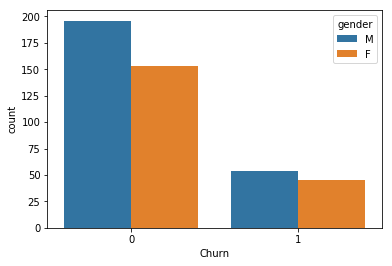

In [12]:
df_gender=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='gender', data=df_gender)

#### level distribution between churn user and normal user

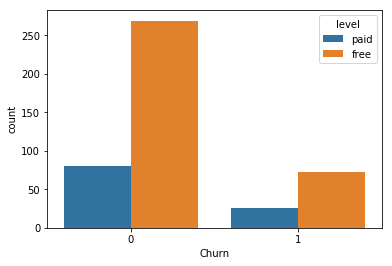

In [13]:
df_level=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='level', data=df_level)

#### method distribution between churn user and normal user

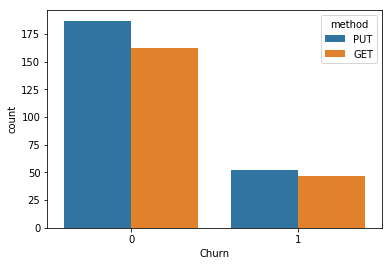

In [14]:
df_method=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "method"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='method', data=df_method)

#### location(state) distribution between churn and normal user

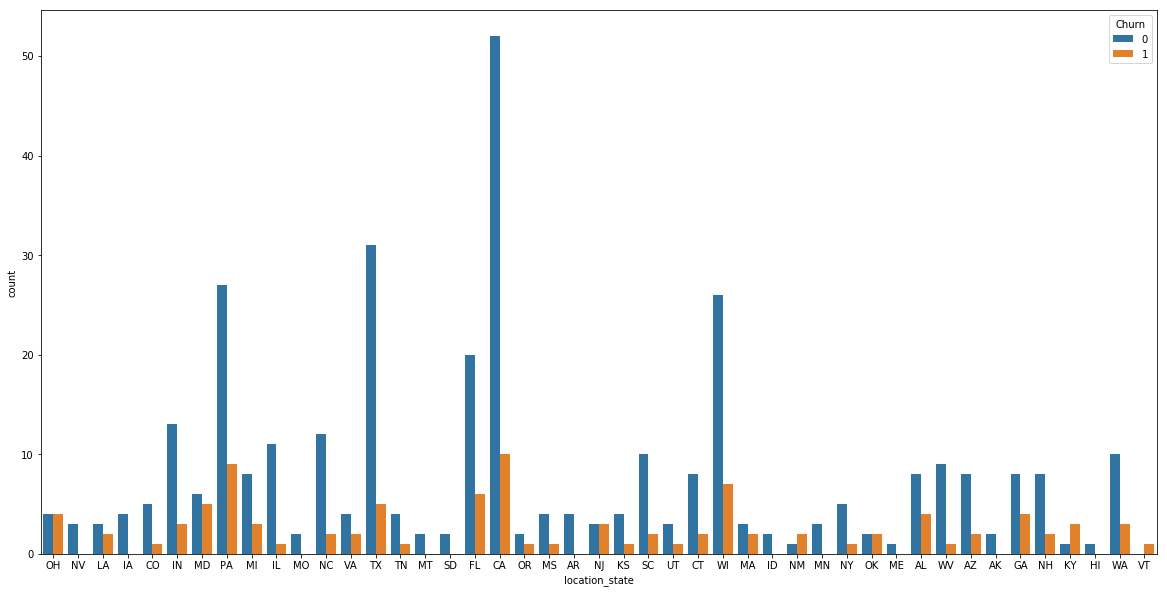

In [15]:
plt.figure(figsize=(20,10))
df_state=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "location_state"]).count().sort("Churn").toPandas()
sns.barplot(x='location_state', y='count', hue='Churn', data=df_state)

#### page distribution between churn user and normal user

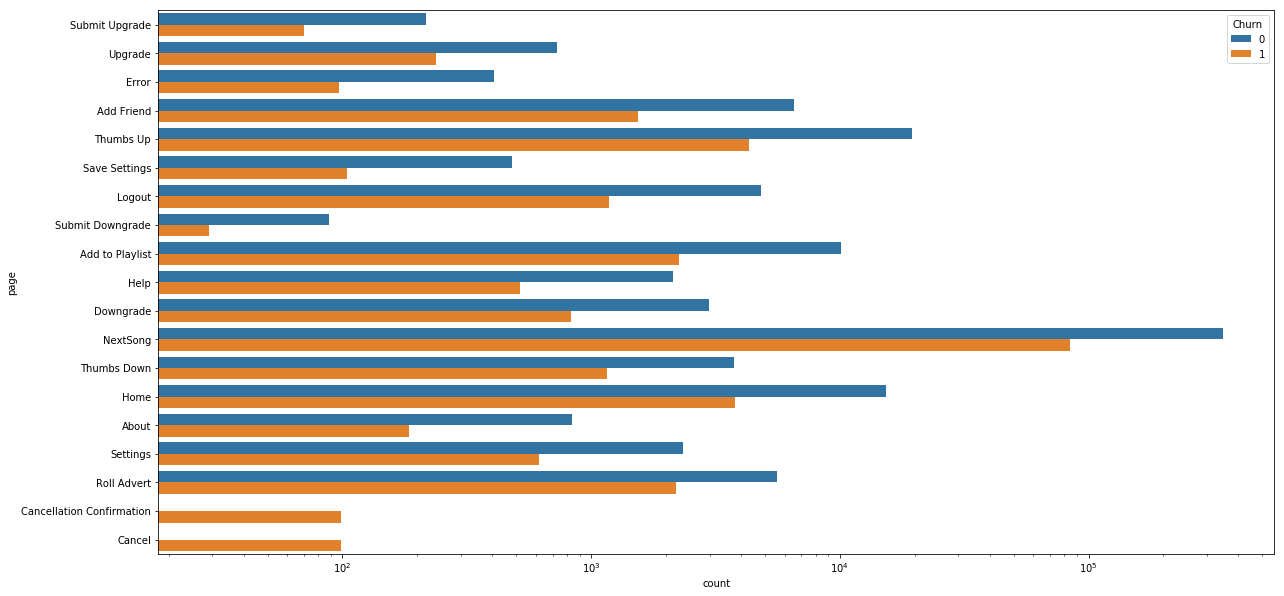

In [121]:
df_page=spark_df_clean.groupby(["Churn", "page"]).count().sort("Churn").toPandas()
#df_page=df_page[(df_page['page']!="Cancellation Confirmation")&(df_page['page']!="Cancel")]
plt.figure(figsize=(20,10))
sns.barplot(x='count', y='page', hue='Churn', data=df_page)
plt.xscale('log')

## Data Exploration-Stage 2 - time sensitive data

I first checked whether there is any difference in periodic user behavior between churn user and normal user. I checked the total number of songs normal and churn user played each hour within a day period, each day within a week period and a month period. However, I did not see any siginicant difference.

#### Time(hours in a day, days in a week, days in a month) distribution for churn user and normal user

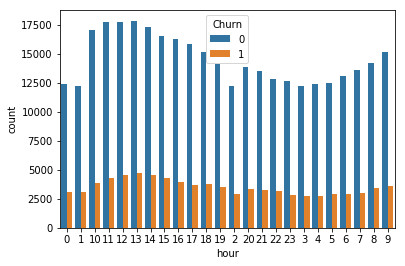

In [19]:
df_hour=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "hour"]).count().sort("Churn").toPandas()
sns.barplot(x='hour', y='count', hue='Churn', data=df_hour)

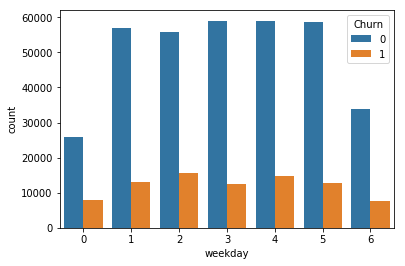

In [20]:
df_weekday=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "weekday"]).count().sort("Churn").toPandas()
sns.barplot(x='weekday', y='count', hue='Churn', data=df_weekday)

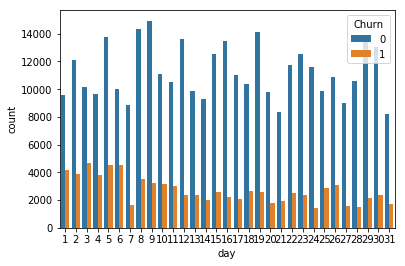

In [21]:
df_day=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "day"]).count().sort("day").toPandas()
df_day['day']=pd.to_numeric(df_day['day'])
df_day=df_day.sort_values('day')
sns.barplot(x='day', y='count', hue='Churn', data=df_day)

Then, I started to exam the user behavior over the whole two months time periods. I did observe some certain churn user interactions, such as 'NextSong', gradually dropped, while normal user's interactions times did not.  after cancellation, churn users will not generate any interaction record. As churn users gradually leaving the service, it is not suprise that the interaction numbers droped overtime.

However, for "roll advert', the number of churn user interaction is as high as normal user. In this dataset, we have more normal users then churn users. Therefore it shows that churn users have a much higher roll advert interaction rate than normal user. This could be an important feature to identify churn user and normal user.


Text(0.5, 1.0, 'total page interaction vs time')

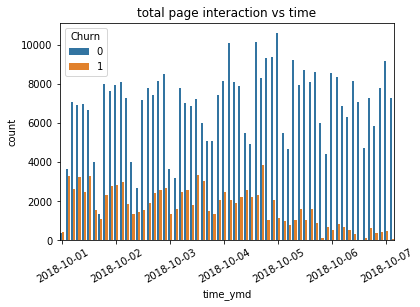

In [74]:
time_page_inter=spark_df_clean.groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);

ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page interaction vs time')

In [24]:
check_user_list=['154','200002','85','234','169','155','300017','101']

In [147]:
time_page_inter_user=spark_df_clean.groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()

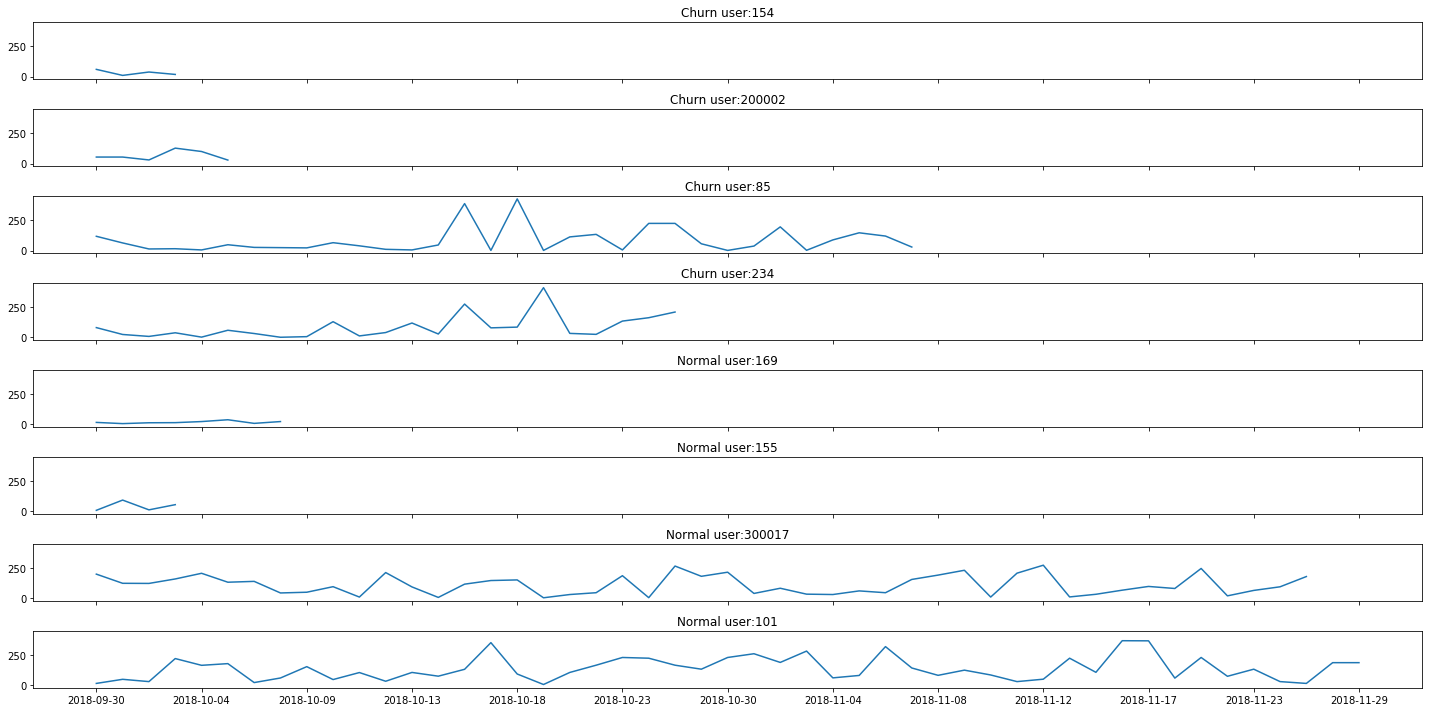

In [148]:
#plt.figure(figsize=(20,10))
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_user[time_page_inter_user['userId']==i]['time_ymd'],time_page_inter_user[time_page_inter_user['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

Text(0.5, 1.0, 'total page-NextSong interaction vs time')

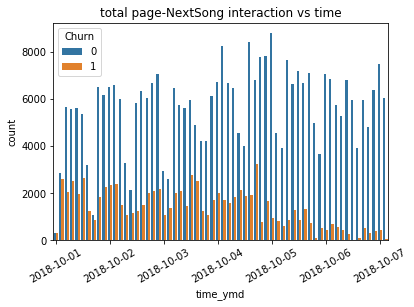

In [75]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-NextSong interaction vs time');

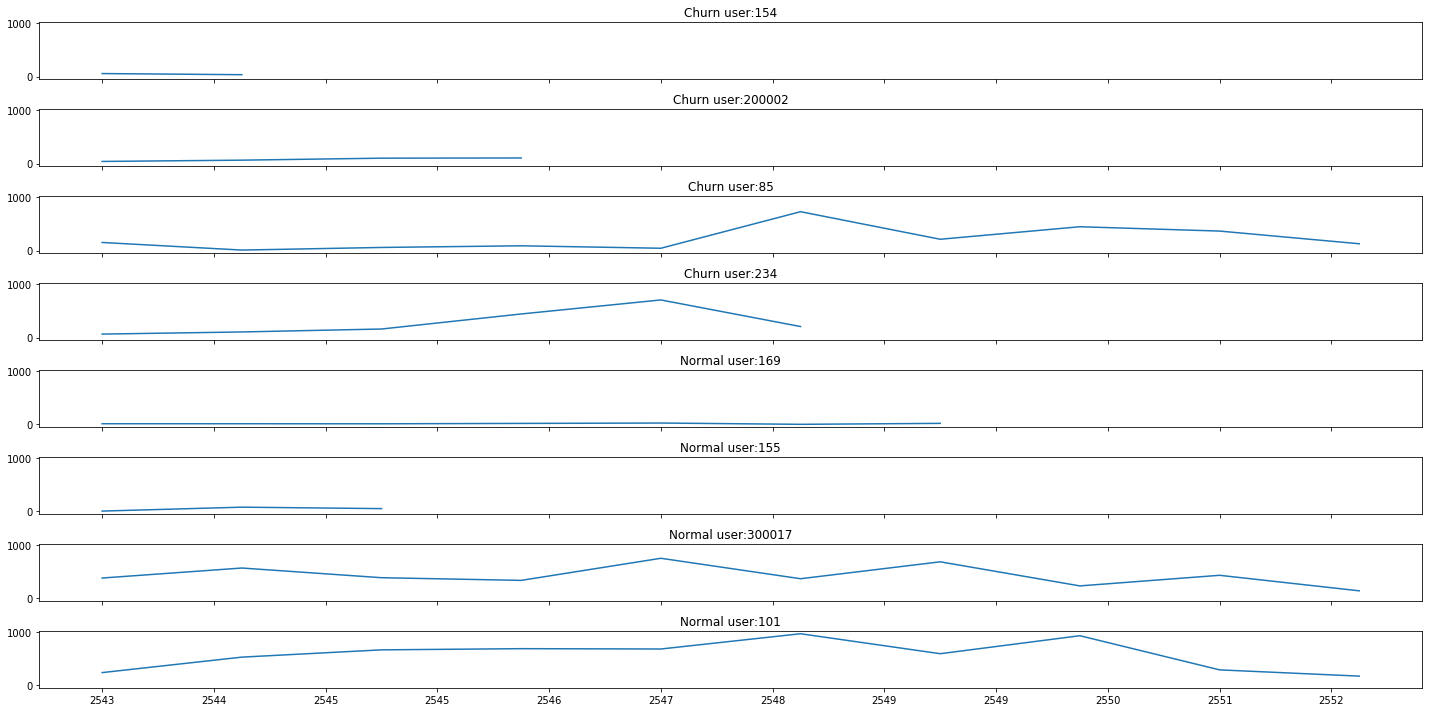

In [195]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby('userId',"time_week").count().sort("time_week").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_week'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

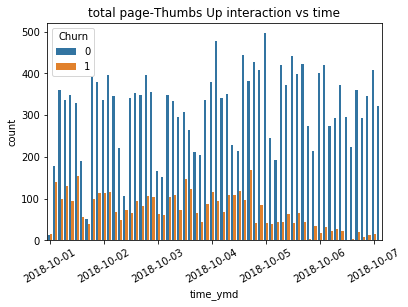

In [76]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Thumbs Up').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Thumbs Up interaction vs time');

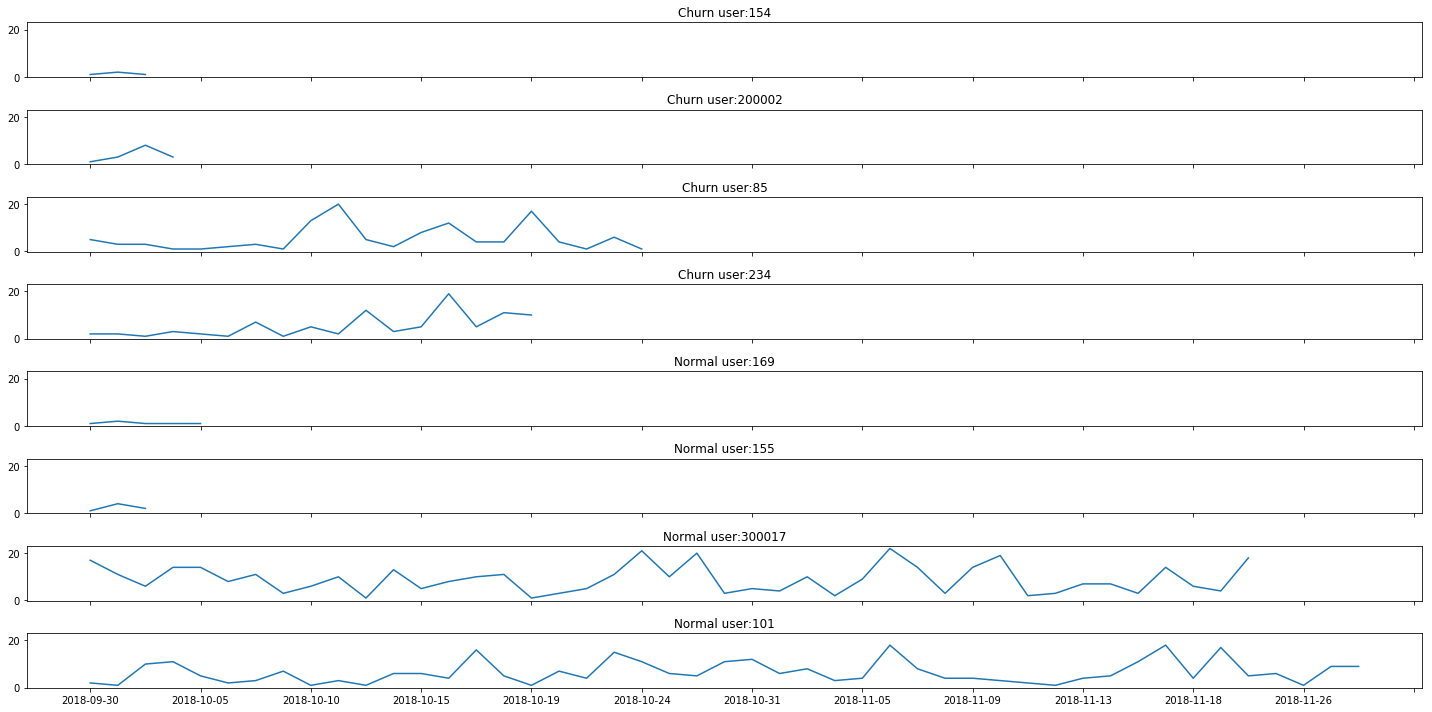

In [153]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Thumbs Up').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

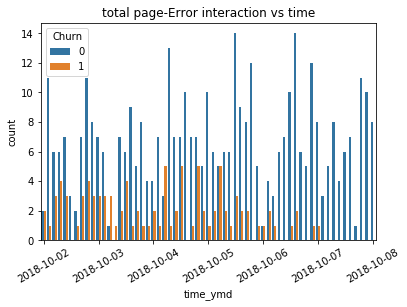

In [157]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Error').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Error interaction vs time');

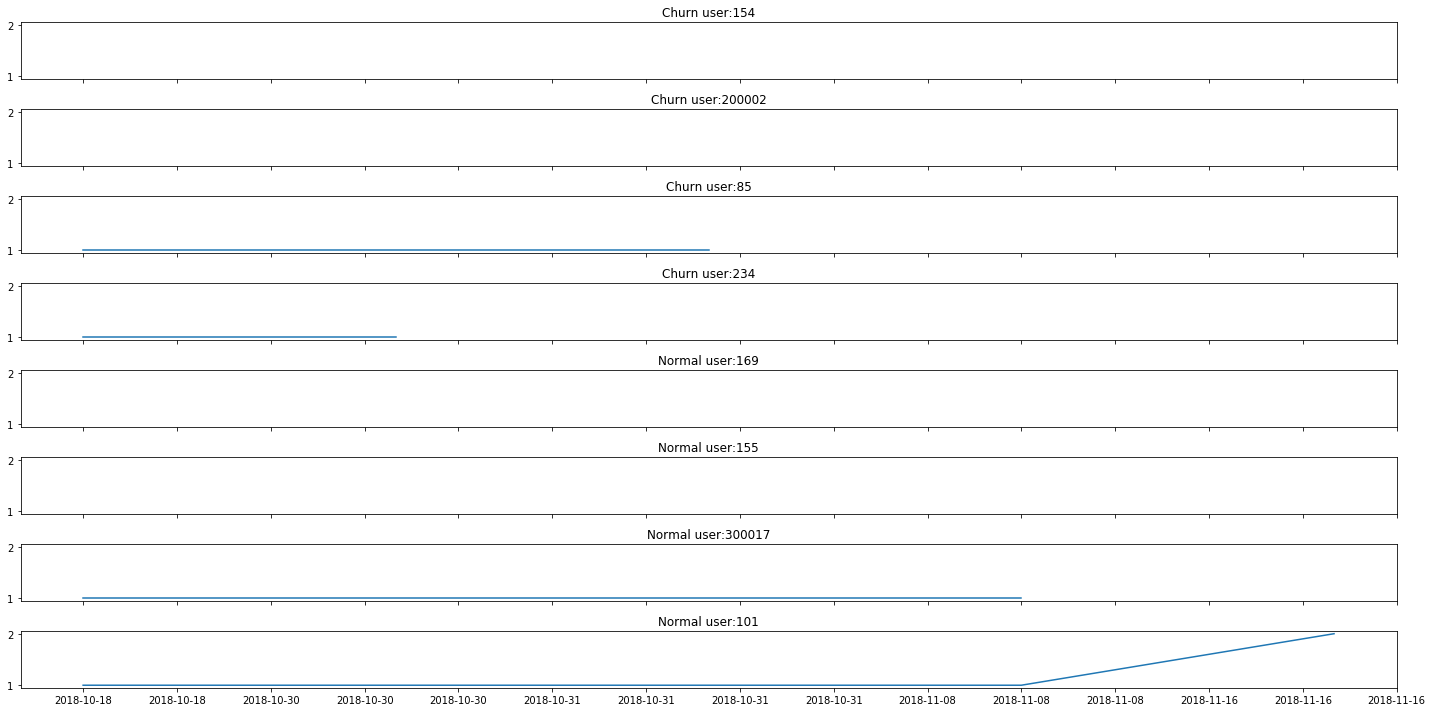

In [154]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Error').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

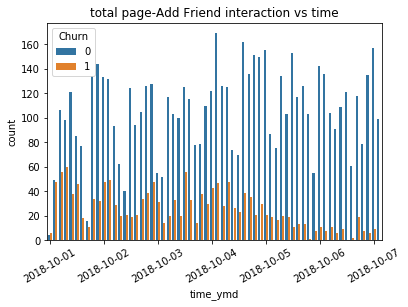

In [158]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Add Friend').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Add Friend interaction vs time');

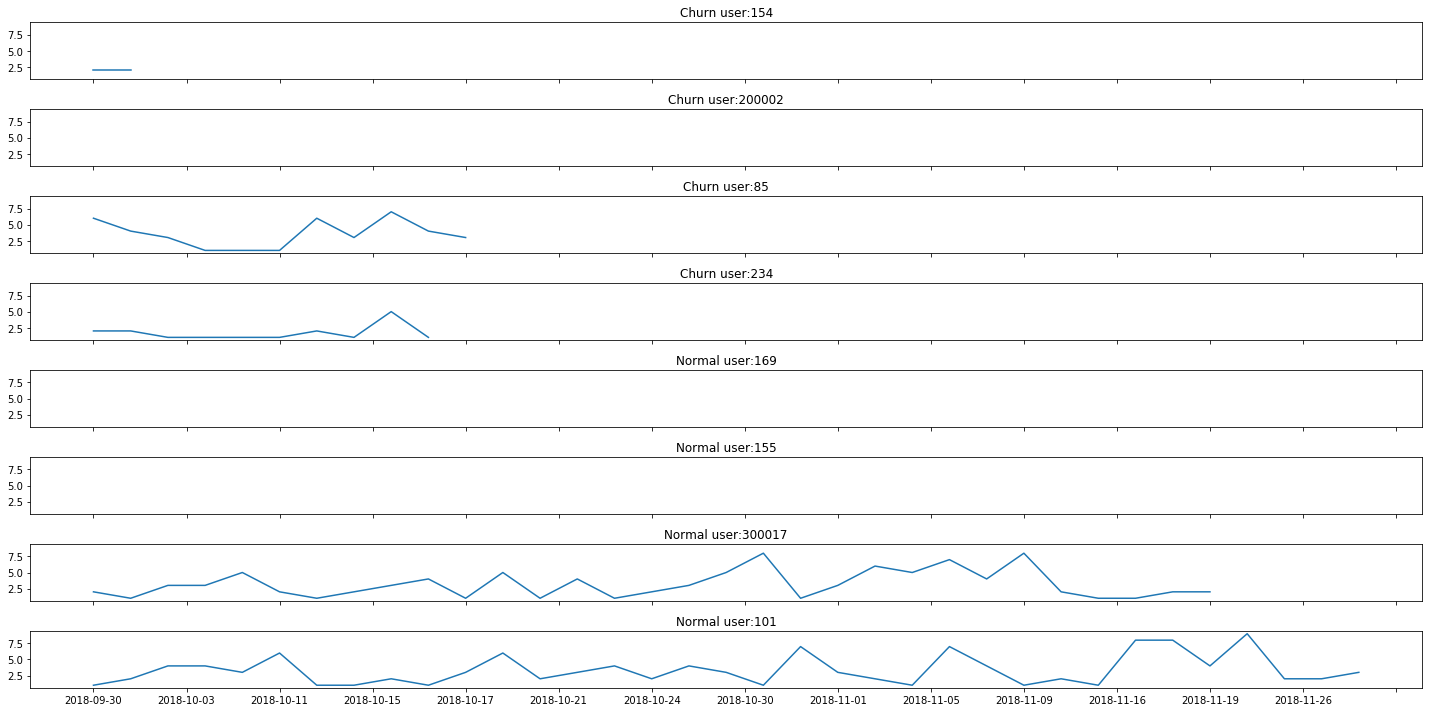

In [155]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Add Friend').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

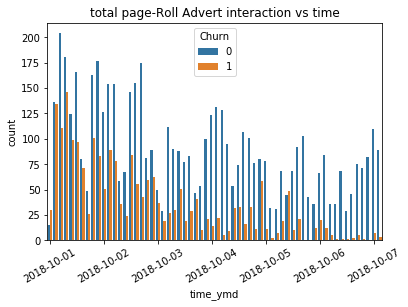

In [159]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Roll Advert').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Roll Advert interaction vs time');

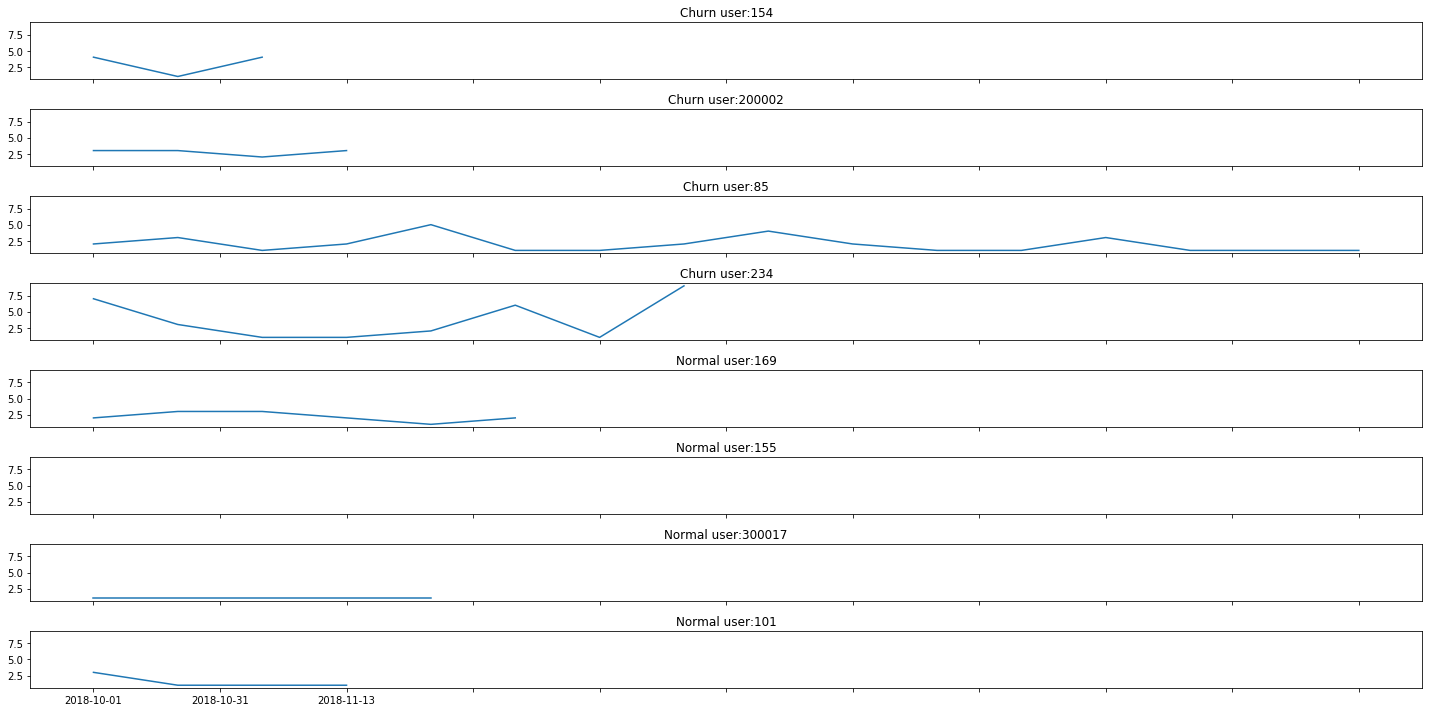

In [123]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Roll Advert').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

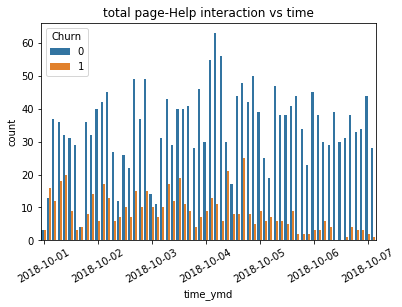

In [161]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Help').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Help interaction vs time');

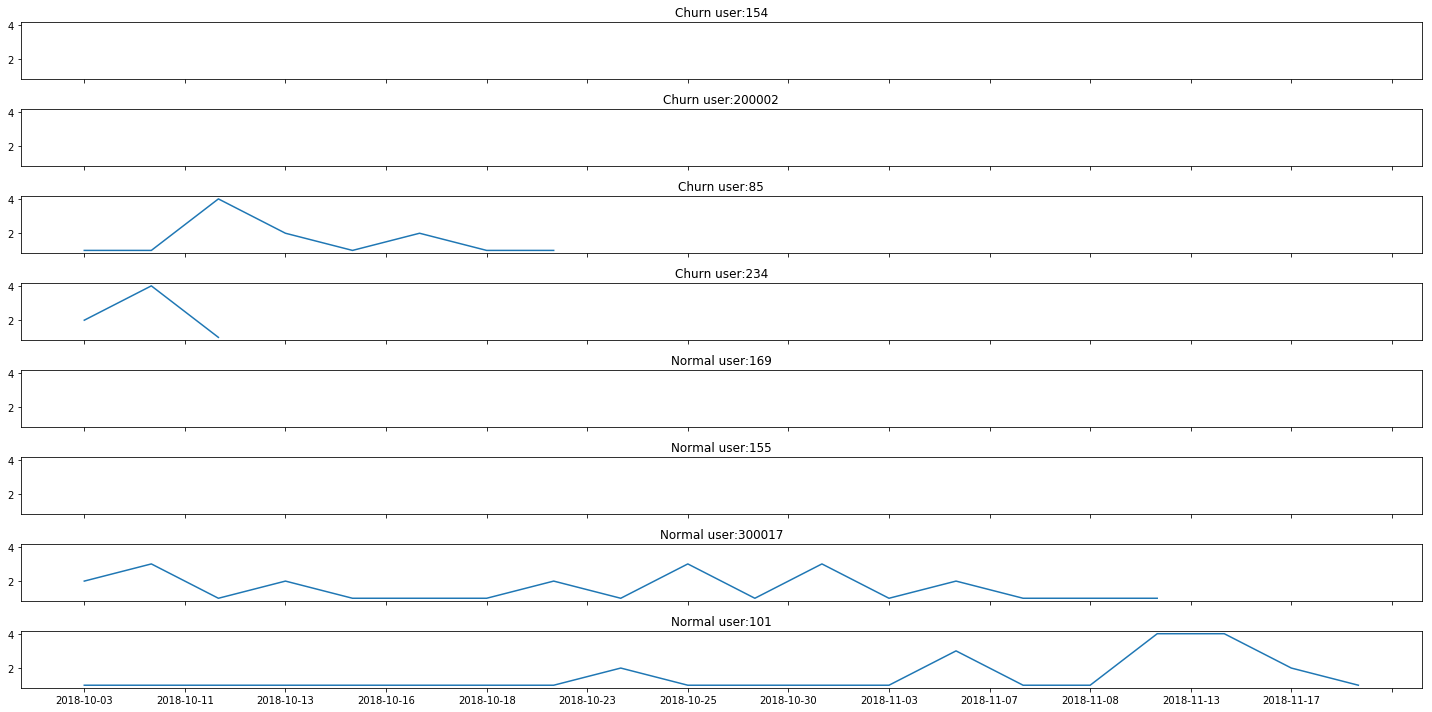

In [160]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Help').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

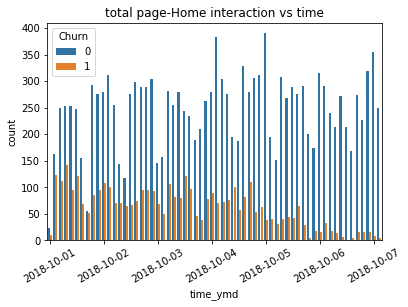

In [162]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Home').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Home interaction vs time');

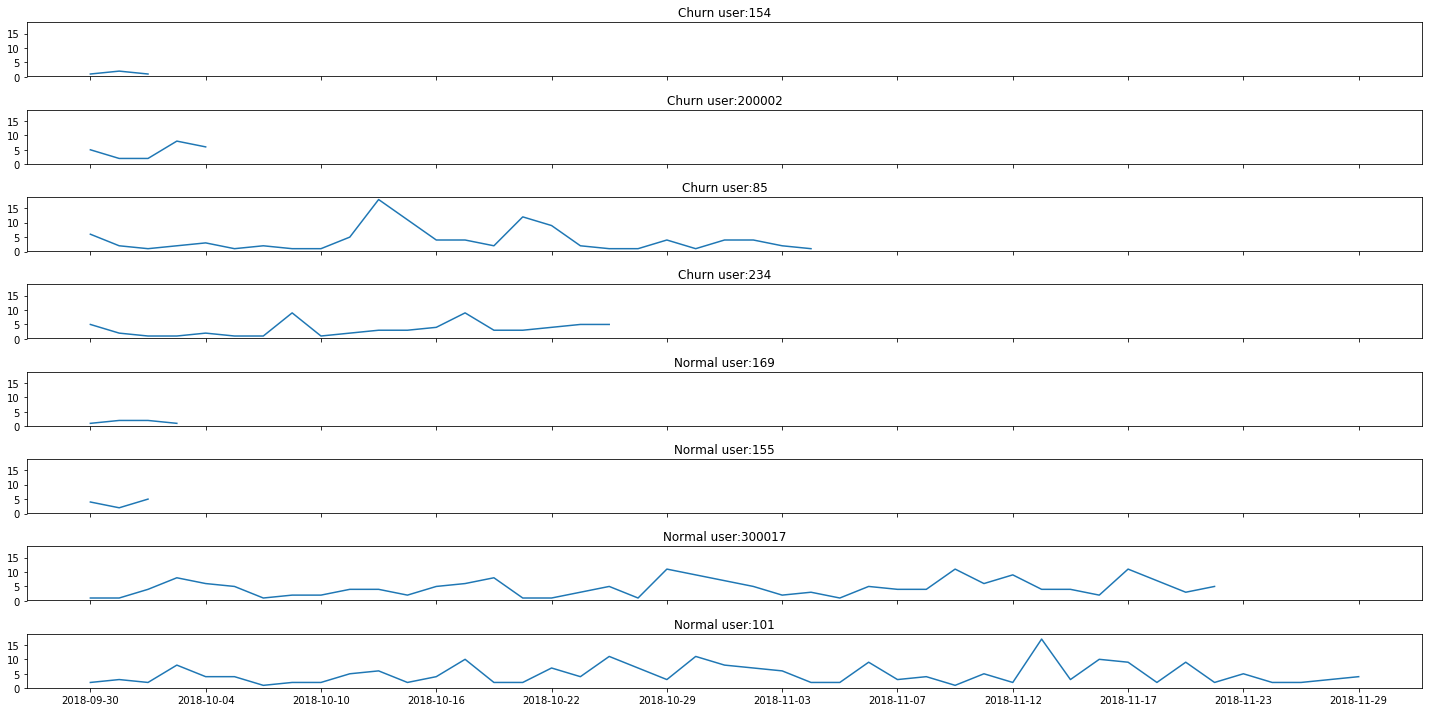

In [163]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Home').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

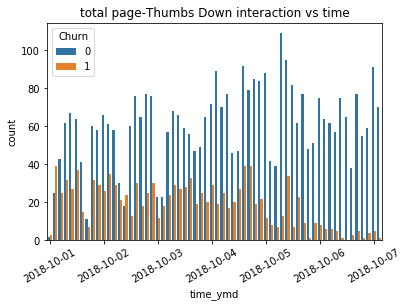

In [164]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Thumbs Down').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Thumbs Down interaction vs time');

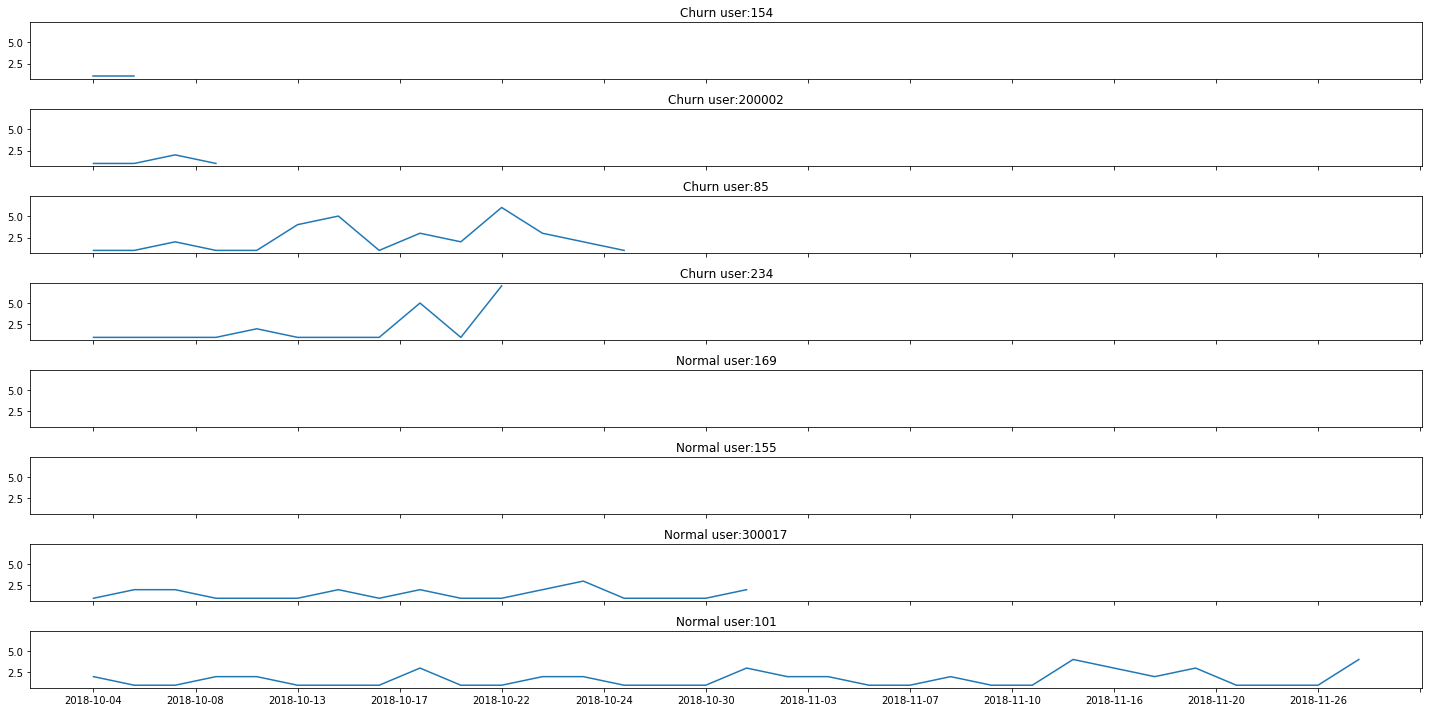

In [165]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']=='Thumbs Down').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

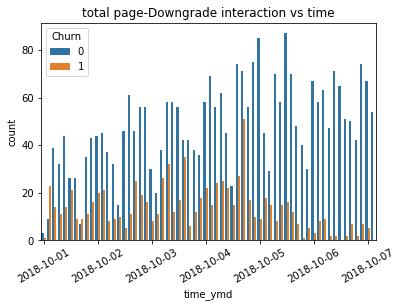

In [166]:
time_page_inter=spark_df_clean.filter(spark_df_clean['page']=='Downgrade').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_page_inter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total page-Downgrade interaction vs time');

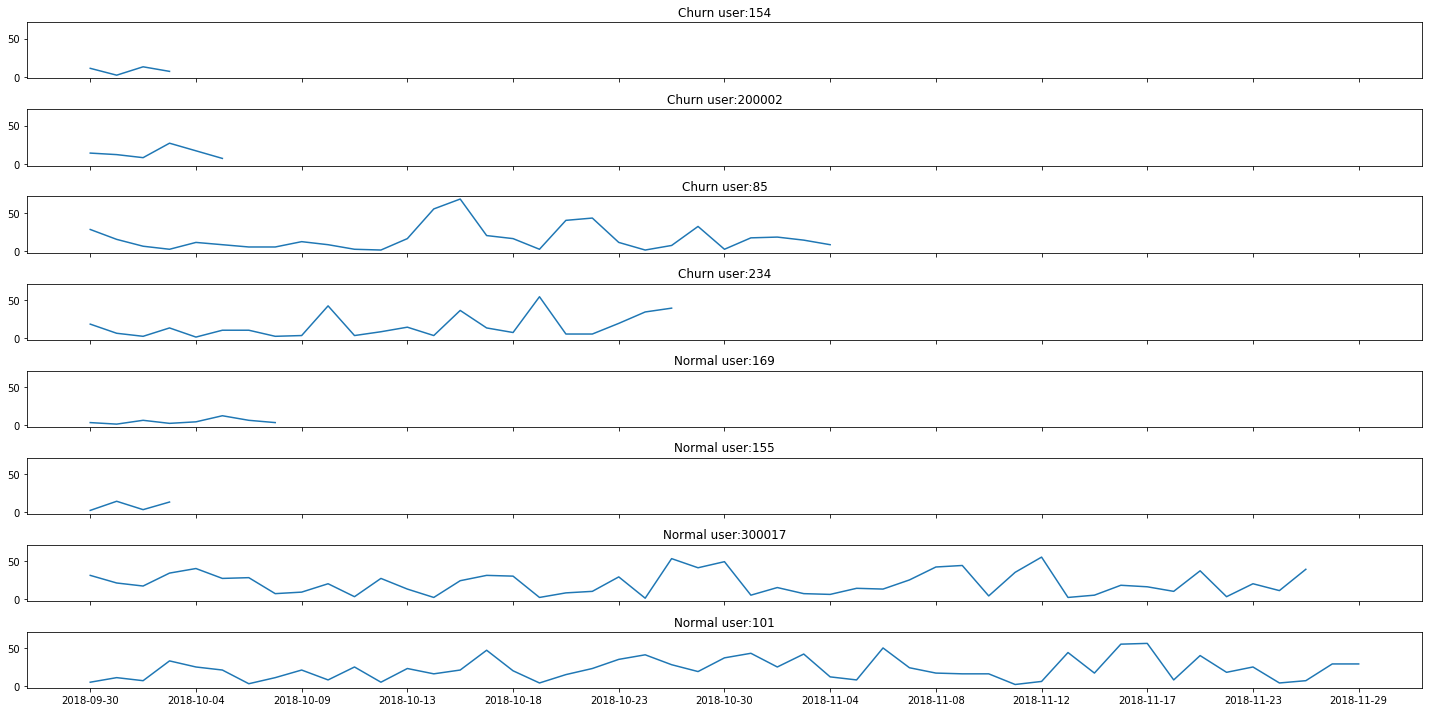

In [28]:
time_page_inter_use=spark_df_clean.filter(spark_df_clean['page']!='NextSong').groupby('userId',"time_ymd").count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_page_inter_use[time_page_inter_use['userId']==i]['time_ymd'],time_page_inter_use[time_page_inter_use['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

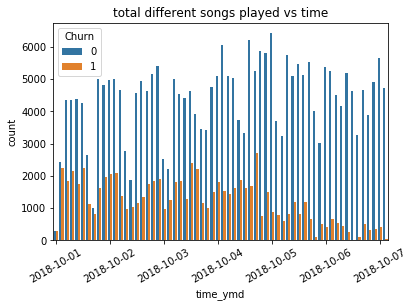

In [177]:
time_song_dist=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby(["Churn", "time_ymd",'song']).count().drop('count').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_song_dist);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total different songs played vs time');

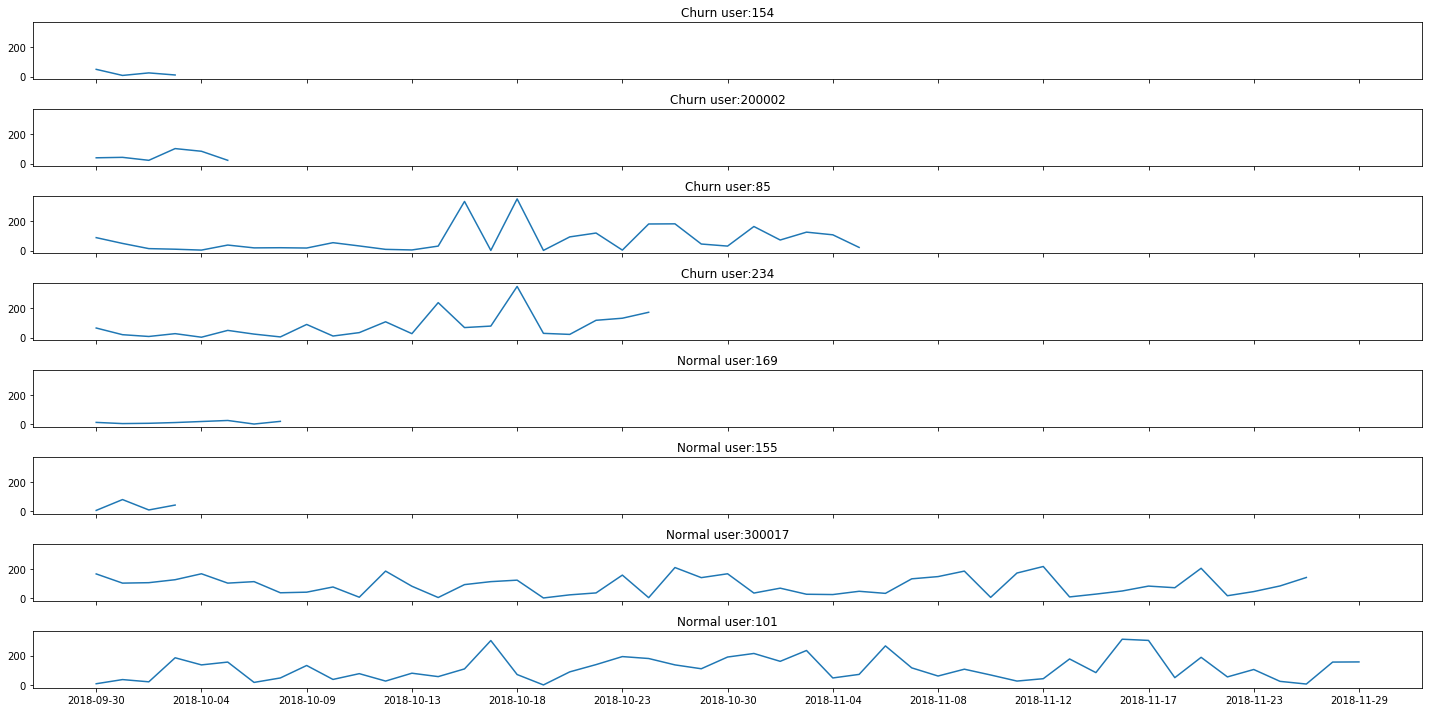

In [178]:
time_song_dist_ind=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby(["userId", "time_ymd",'song']).count().drop('count').groupby(["userId", "time_ymd"]).count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_song_dist_ind[time_song_dist_ind['userId']==i]['time_ymd'],time_song_dist_ind[time_song_dist_ind['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

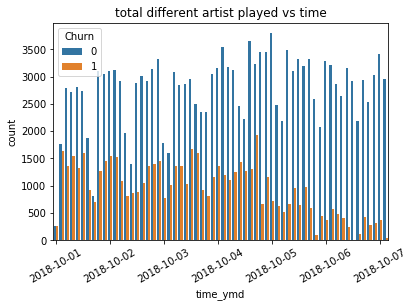

In [179]:
time_song_dist=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby(["Churn", "time_ymd",'artist']).count().drop('count').groupby(["Churn", "time_ymd"]).count().sort("time_ymd").toPandas()
ax = sns.barplot(x='time_ymd', y='count', hue='Churn', data=time_song_dist);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('total different artist played vs time');

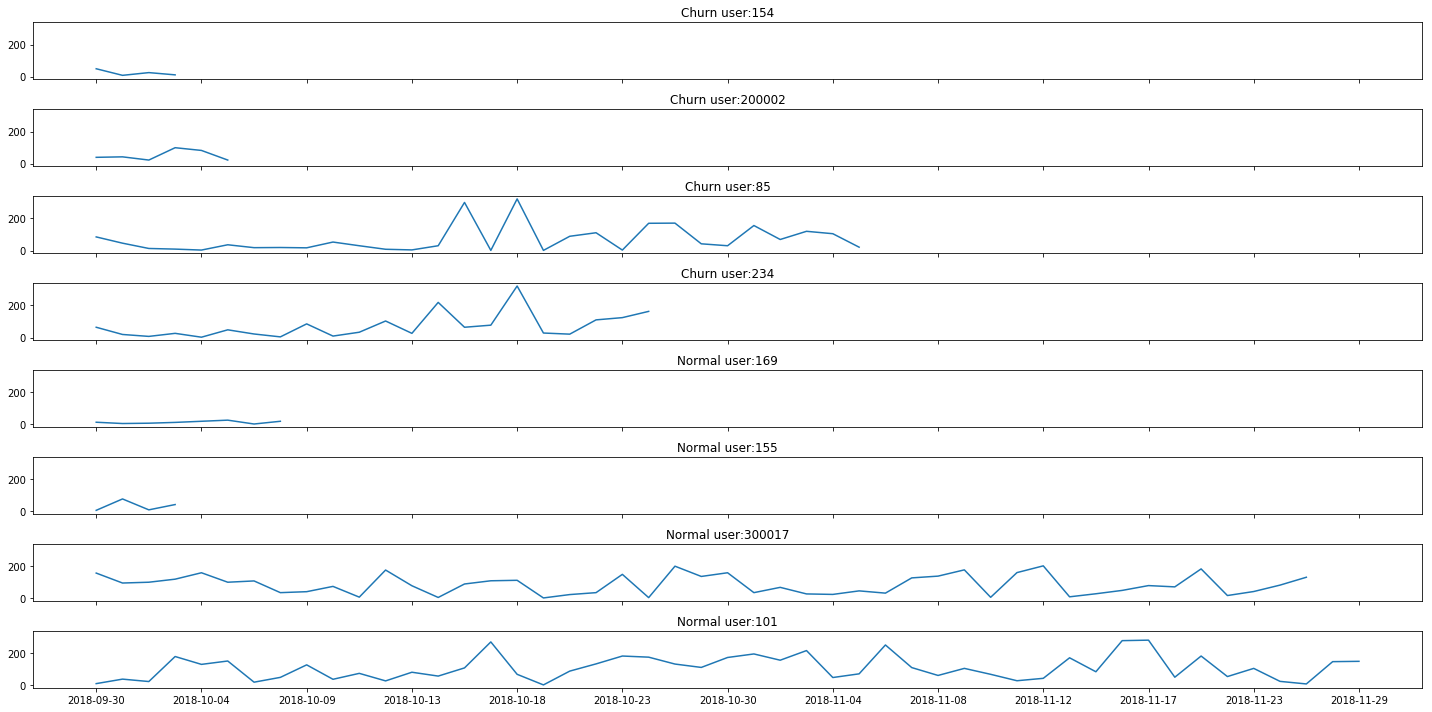

In [180]:
time_song_dist_ind=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby(["userId", "time_ymd",'artist']).count().drop('count').groupby(["userId", "time_ymd"]).count().sort("time_ymd").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_song_dist_ind[time_song_dist_ind['userId']==i]['time_ymd'],time_song_dist_ind[time_song_dist_ind['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

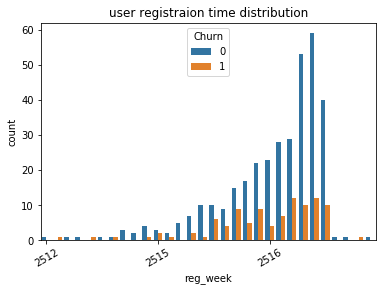

In [194]:
churn_regtime=spark_df_clean.groupby(["Churn", "reg_week",'userId',]).count().drop('count').groupby(["Churn", "reg_week"]).count().sort("reg_week").toPandas()
ax = sns.barplot(x='reg_week', y='count', hue='Churn', data=churn_regtime);
ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('user registraion time distribution');

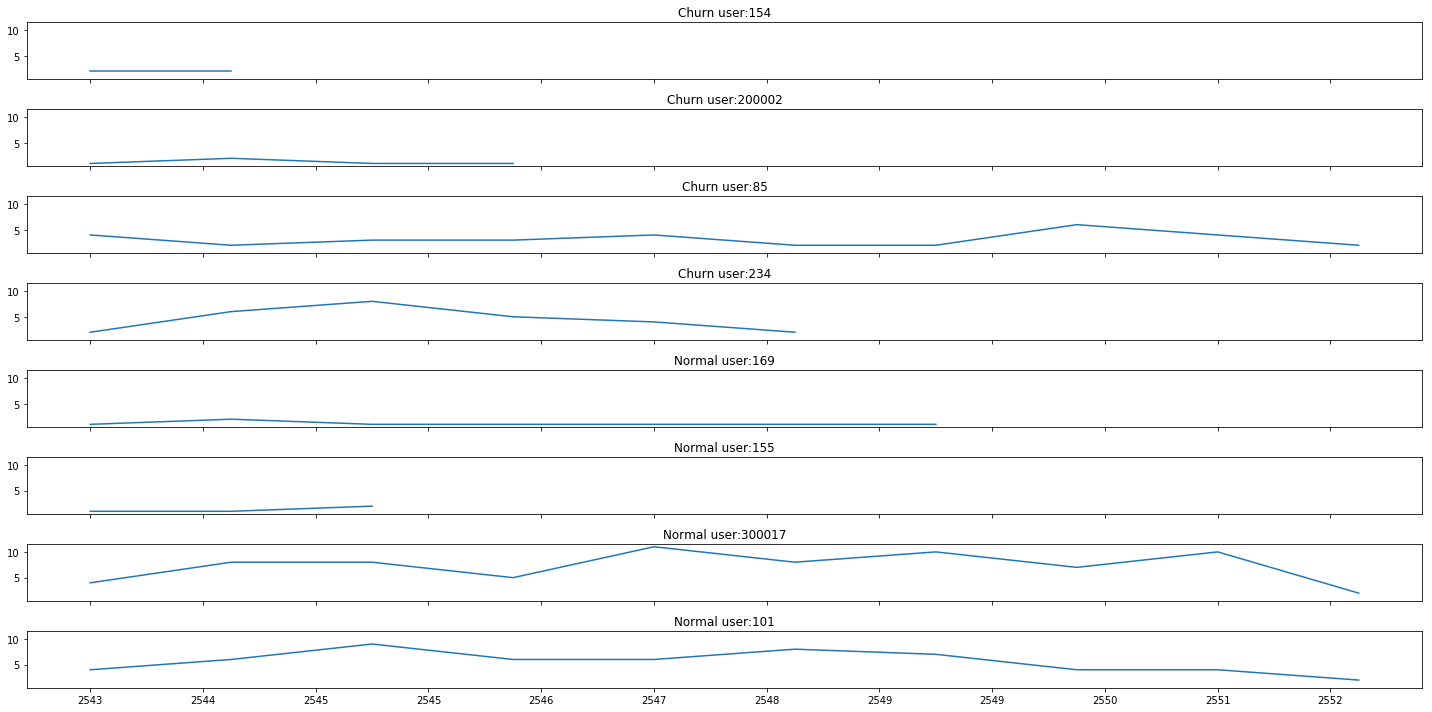

In [26]:
# played session number vs time
time_session_ind=spark_df_clean.groupby(["userId", "time_week",'sessionId']).count().drop('count').groupby(["userId", "time_week"]).count().sort("time_week").toPandas()
fig, ax=plt.subplots(8, 1, sharex='all',sharey='all',figsize=(20,10))
count=0
for i in check_user_list:
    ax[count].plot(time_session_ind[time_session_ind['userId']==i]['time_week'],time_session_ind[time_session_ind['userId']==i]['count'])
    ax[count].xaxis.set_major_locator(MaxNLocator(nbins=16))
    if count<4:
        ax[count].set_title('Churn user:'+i)
    else:
        ax[count].set_title('Normal user:'+i)
    count=count+1
plt.tight_layout()

## Data Exploration-Stage 3 - session sensititve data

In this stage, I examed user's interaction pattern in each session.It seems that churn users have more NextSong, add to playlist, roll advert, downgrade,thumbs down and home interaction per session than normal user
In addtion, normal users played more sessions than churn user, while churn users stay longer time in each session than normal user.

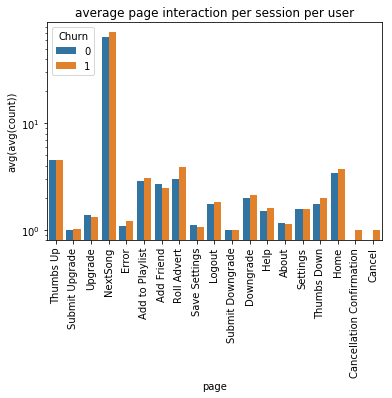

In [60]:
tempdf1=spark_df_clean.groupby('Churn','userId','page','sessionId').count().sort('userId')
tempdf2=tempdf1.groupby('Churn','userId','page').avg('count')
tempdf3=tempdf2.groupby("Churn",'page').avg('avg(count)').toPandas()
ax = sns.barplot(x='page', y='avg(avg(count))', hue='Churn', data=tempdf3);
#ax.xaxis.set_major_locator(ticker.MultipleLocator(10));
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
ax.set_title('average page interaction per session per user');
plt.yscale('log')

In [62]:
tempdf1=spark_df_clean.groupby('Churn',"userId",'sessionId').agg(((max(spark_df_clean['ts'])-min(spark_df_clean['ts']))/1000/60).alias('sessiontime')).sort('userId','sessionId')
tempdf1.show(2)

+-----+------+---------+------------------+
|Churn|userId|sessionId|       sessiontime|
+-----+------+---------+------------------+
|    1|    10|        9|            1502.4|
|    0|   100|      497|135.13333333333333|
+-----+------+---------+------------------+
only showing top 2 rows



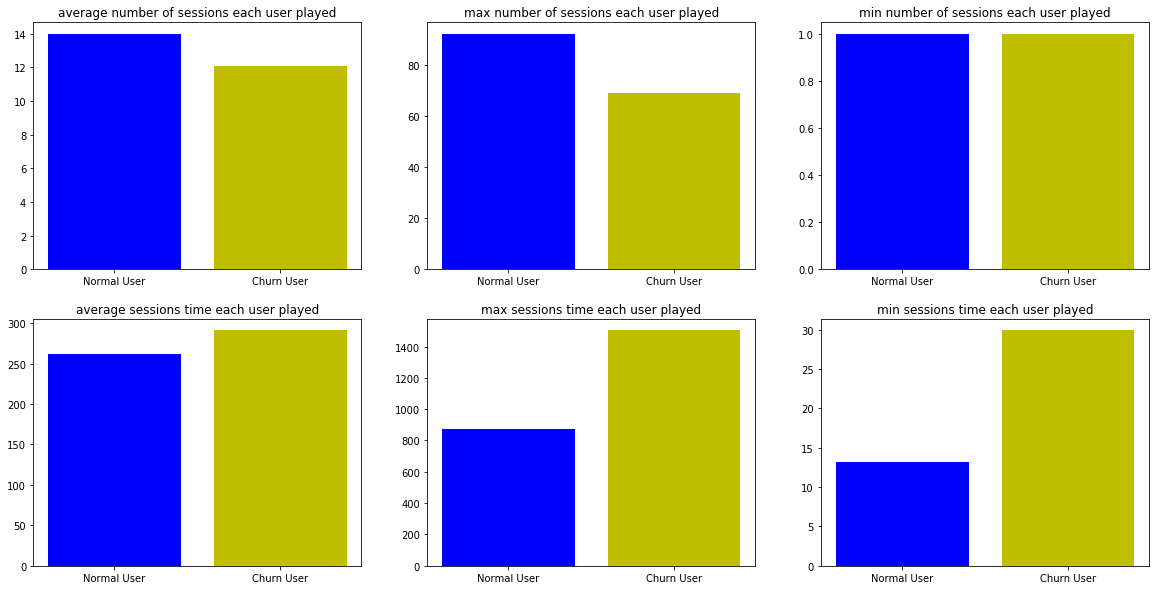

In [120]:
fig, ax=plt.subplots(2, 3,figsize=(20,10))

tempdf_sessioncount=tempdf1.groupby("Churn",'userId').count().groupby("Churn").avg('count').toPandas()
ax[0,0].bar(tempdf_sessioncount['Churn'],tempdf_sessioncount['avg(count)'],color=('b','y'))
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,0].set_xticklabels(('Normal User',"Churn User"))
ax[0,0].set_title('average number of sessions each user played');

tempdf_sessioncount_max=tempdf1.groupby("Churn",'userId').count().groupby("Churn").max('count').toPandas()
ax[0,1].bar(tempdf_sessioncount_max['Churn'],tempdf_sessioncount_max['max(count)'],color=('b','y'))
ax[0,1].set_xticklabels(('Normal User',"Churn User"))
ax[0,1].set_title('max number of sessions each user played');

tempdf_sessioncount_min=tempdf1.groupby("Churn",'userId').count().groupby("Churn").min('count').toPandas()
ax[0,2].bar(tempdf_sessioncount_min['Churn'],tempdf_sessioncount_min['min(count)'],color=('b','y'))
ax[0,2].set_xticklabels(('Normal User',"Churn User"))
ax[0,2].set_title('min number of sessions each user played');

tempdf_sessiontime=tempdf1.groupby("Churn",'userId').avg('sessiontime').groupby("Churn").avg('avg(sessiontime)').toPandas()
ax[1,0].bar(tempdf_sessiontime['Churn'],tempdf_sessiontime['avg(avg(sessiontime))'],color=('b','y'))
ax[1,0].set_xticklabels(('Normal User',"Churn User"))
ax[1,0].set_title('average sessions time each user played');

tempdf_sessiontime_max=tempdf1.groupby("Churn",'userId').avg('sessiontime').groupby("Churn").max('avg(sessiontime)').toPandas()
ax[1,1].bar(tempdf_sessiontime_max['Churn'],tempdf_sessiontime_max['max(avg(sessiontime))'],color=('b','y'))
ax[1,1].set_xticklabels(('Normal User',"Churn User"))
ax[1,1].set_title('max sessions time each user played');

tempdf_sessiontime_min=tempdf1.groupby("Churn",'userId').avg('sessiontime').groupby("Churn").min('avg(sessiontime)').toPandas()
ax[1,2].bar(tempdf_sessiontime_min['Churn'],tempdf_sessiontime_min['min(avg(sessiontime))'],color=('b','y'))
ax[1,2].set_xticklabels(('Normal User',"Churn User"))
ax[1,2].set_title('min sessions time each user played');
